# profiling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import random
from timeit import timeit

def randt(n):
    return tuple(random() for _ in range(n))

def isclose(*a):
    return all(np.isclose(a[0], ai) for ai in a[1:])

def allclose(*a):
    return all(np.allclose(a[0], ai) for ai in a[1:])


def compare(x, *ys, title=None):
    fig, axs = plt.subplots(ncols=2, sharex=True)
    for i, y in enumerate(ys):
        axs[0].scatter(x, np.multiply(y, 1e3), marker='o', s=(72./fig.dpi)**2, label=f'$f_{i}$')
    axs[0].set_yscale('log')
    axs[0].set_xlabel('$n$ / 1')
    axs[0].set_ylabel('$t$ / ms')
    axs[0].legend()
    axs[0].set_title('Absolute')
    
    for i, y in enumerate(ys):
        axs[1].scatter(x, np.divide(y, ys[0]), marker='o', s=(72./fig.dpi)**2, label=f'$f_{i}$ / $f_0$')
    #axs[1].axhline(1, linestyle='--', lw=0.5)
    axs[1].set_yscale('log')
    axs[1].set_xlabel('$n$ / 1')
    axs[1].set_ylabel('$t$ / 1')
    axs[1].set_title('Relative')
    axs[1].legend()
    plt.tight_layout()
    plt.show()


def measure(supplier, *f, n=10000, N=4, scalar=True):
    x, y = [], [[] for _ in range(len(f))]
    for _ in range(n):
        args = supplier()
        x += [args[0]]
        args = args[1:]
        if scalar:
            assert isclose(*(fi(*args) for fi in f))
        else:
            assert allclose(*(fi(*args) for fi in f))
        for fi, yi in zip(f, y):
            yi += [timeit(lambda: fi(*args), number=N) / N]
    return x, *y

## trim

In [2]:
def trim0(v, tol):
    while v and abs(v[-1])<=tol:
        v = v[:-1]
    return v

def trim1(v, tol):
    return v[:len(v)-next((i for i, vi in enumerate(reversed(v)) if abs(vi)>tol), len(v))]

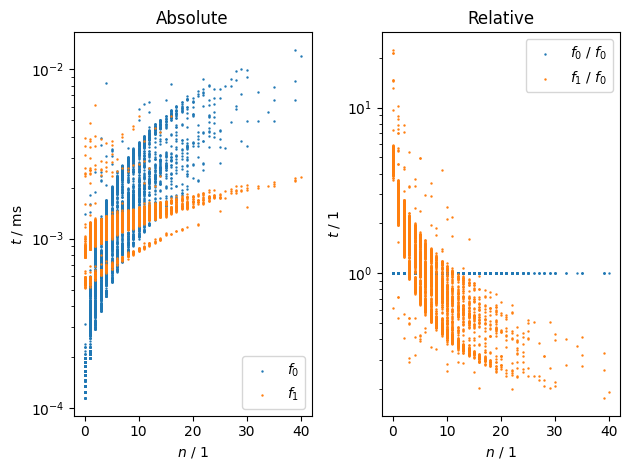

In [3]:
from random import randint

tol = 0.8
def supplier():
    v = randt(randint(0, 100))
    return len(v)-len(trim0(v, tol)), v, tol

compare(*measure(supplier, trim0, trim1, scalar=False))

## dot

In [4]:
from itertools import starmap
from operator import mul
from math import sumprod

def dot0(v, w):
    return sum(map(mul, v, w))

def dot1(v, w):
    #https://docs.python.org/3/library/itertools.html
    return sum(starmap(mul, zip(v, w)))

def dot2(v, w):
    return sumprod(v[:min(len(v), len(w))], w[:min(len(v), len(w))])

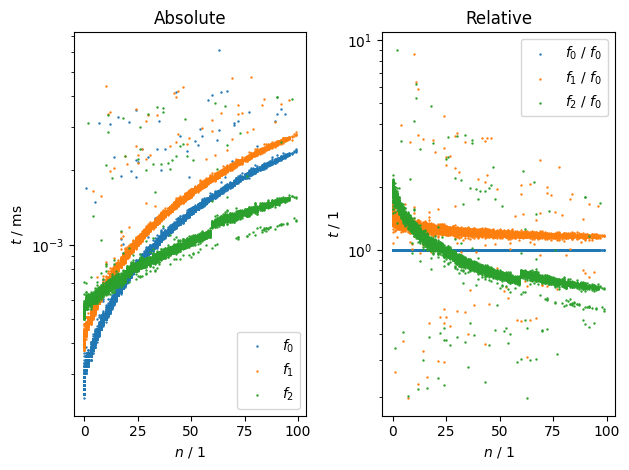

In [5]:
def supplier():
    v, w = randt(randint(0, 100)), randt(randint(0, 100))
    return min(len(v), len(w)), v, w

compare(*measure(supplier, dot0, dot1, dot2))

## norm

In [6]:
from math import sqrt, hypot

def norm0(v):
    return hypot(*v)

def norm1(v):
    return sqrt(sumprod(v, v))

def dot(v, w):
    return sum(map(mul, v, w))

def norm2(v):
    return sqrt(dot(v, v))

def norm3(v):
    return sqrt(sum(vi**2 for vi in v))

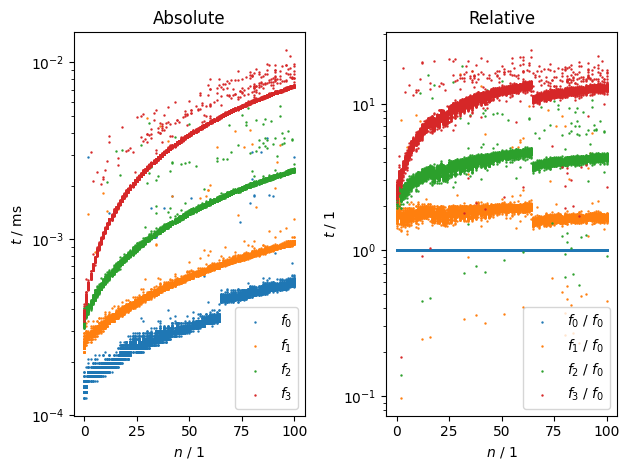

In [7]:
def supplier():
    v = randt(randint(0, 100))
    return len(v), v

compare(*measure(supplier, norm0, norm1, norm2, norm3))

## abssq

In [8]:
def abssq0(v):
    return sumprod(v, v)

def abssq1(v):
    return sum(map(mul, v, v))

def abssq2(v):
    return sum(vi**2 for vi in v)

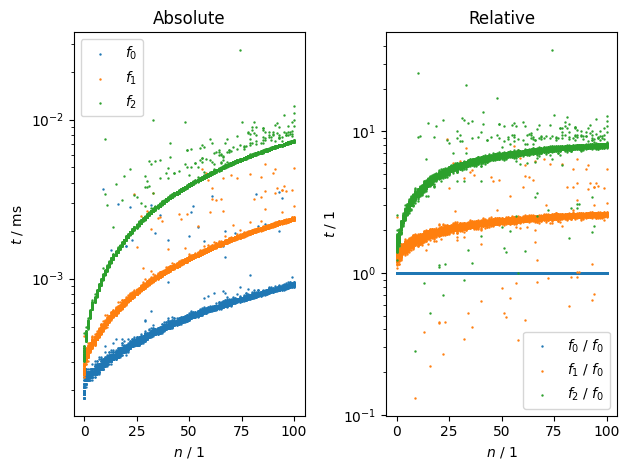

In [9]:
compare(*measure(supplier, abssq0, abssq1, abssq2))

## add

In [10]:
from operator import add
from itertools import zip_longest

def add0(v, w):
    return tuple(starmap(add, zip_longest(v, w, fillvalue=0)))

def add1(v, w):
    return tuple(vi+wi for vi, wi in zip_longest(v, w, fillvalue=0))

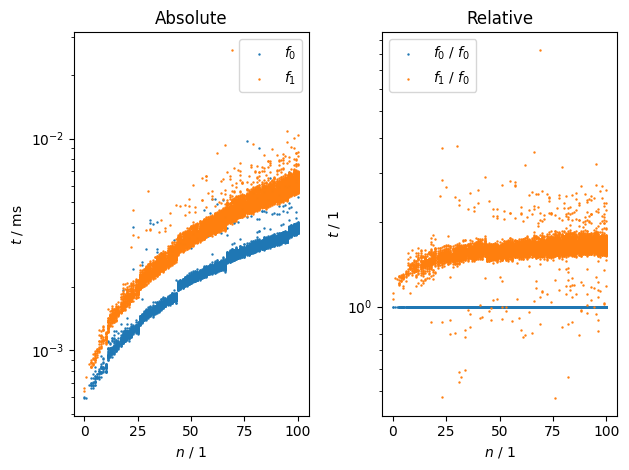

In [11]:
def supplier():
    v, w = randt(randint(0, 100)), randt(randint(0, 100))
    return max(len(v), len(w)), v, w

compare(*measure(supplier, add0, add1, scalar=False))

## addscalar

In [12]:
from itertools import repeat

def addscalar0(v, a):
    return tuple(map(add, v, repeat(a)))

def addscalar1(v, a):
    return tuple(vi+a for vi in v)

def addscalar2(v, a):
    return tuple(map(lambda vi: vi+a, v))

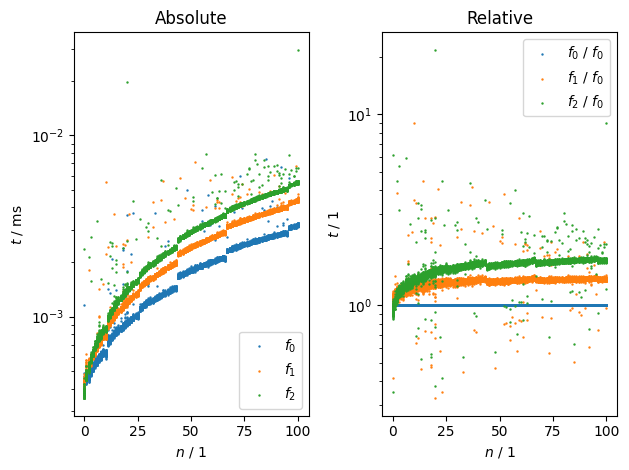

In [13]:
def supplier():
    v, a = randt(randint(0, 100)), random()
    return len(v), v, a

compare(*measure(supplier, addscalar0, addscalar1, addscalar2, scalar=False))

## sub

In [14]:
from operator import sub

def sub0(v, w):
    return tuple(starmap(sub, zip_longest(v, w, fillvalue=0)))

def sub1(v, w):
    return tuple(vi-wi for vi, wi in zip_longest(v, w, fillvalue=0))

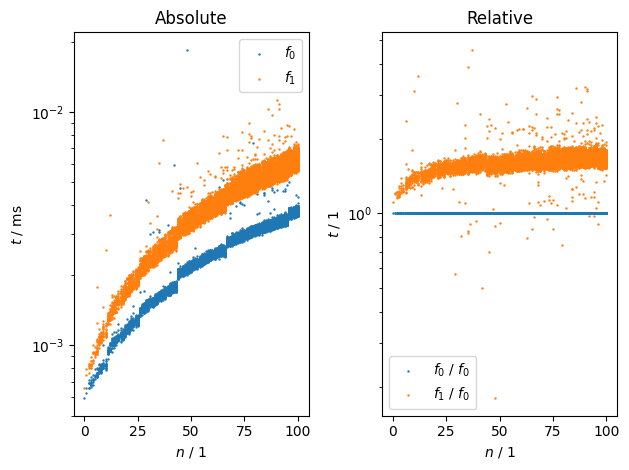

In [15]:
def supplier():
    v, w = randt(randint(0, 100)), randt(randint(0, 100))
    return max(len(v), len(w)), v, w

compare(*measure(supplier, sub0, sub1, scalar=False))

## subscalar

In [16]:
def subscalar0(v, a):
    return tuple(map(sub, v, repeat(a)))

def subscalar1(v, a):
    return tuple(vi-a for vi in v)

def subscalar2(v, a):
    return tuple(map(lambda vi: vi-a, v))

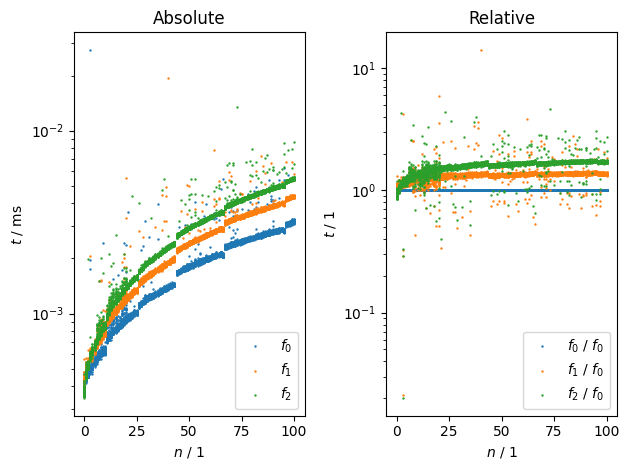

In [17]:
def supplier():
    v, a = randt(randint(0, 100)), random()
    return len(v), v, a

compare(*measure(supplier, subscalar0, subscalar1, subscalar2, scalar=False))

## mul

In [18]:
def mul0(a, v):
    return tuple(map(mul, repeat(a), v))

def mul1(a, v):
    return tuple(a*vi for vi in v)

def mul2(a, v):
    return tuple(map(lambda vi: a*vi, v))

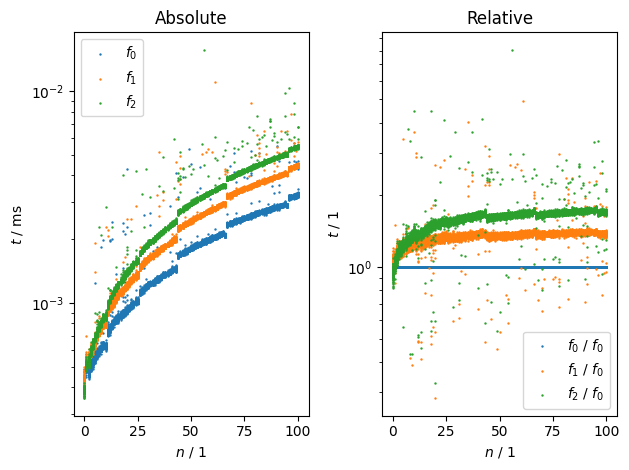

In [19]:
def supplier():
    a, v = random(), randt(randint(0, 100))
    return len(v), a, v

compare(*measure(supplier, mul0, mul1, mul2, scalar=False))

## mulelementwise

In [20]:
def mulelementwise0(v, w):
    return tuple(map(mul, v, w))

def mulelementwise1(v, w):
    return tuple(vi*wi for vi, wi in zip(v, w))

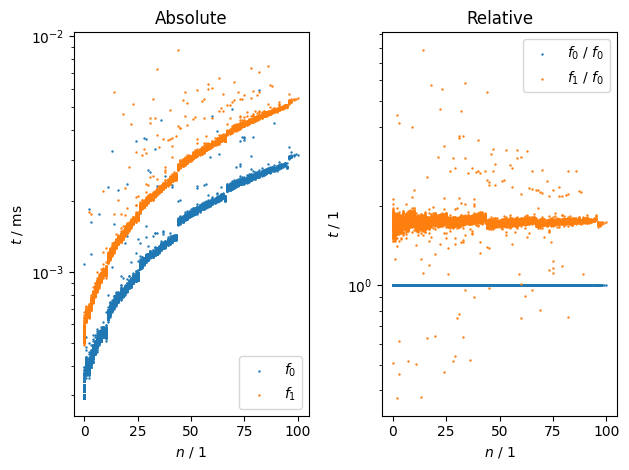

In [21]:
def supplier():
    v, w = randt(randint(0, 100)), randt(randint(0, 100))
    return min(len(v), len(w)), v, w

compare(*measure(supplier, mulelementwise0, mulelementwise1, scalar=False))

# div

In [22]:
from operator import truediv

def div0(v, a):
    return tuple(map(truediv, v, repeat(a)))

def div1(v, a):
    return tuple(vi/a for vi in v)

def div2(v, a):
    return tuple(map(lambda vi: vi/a, v))

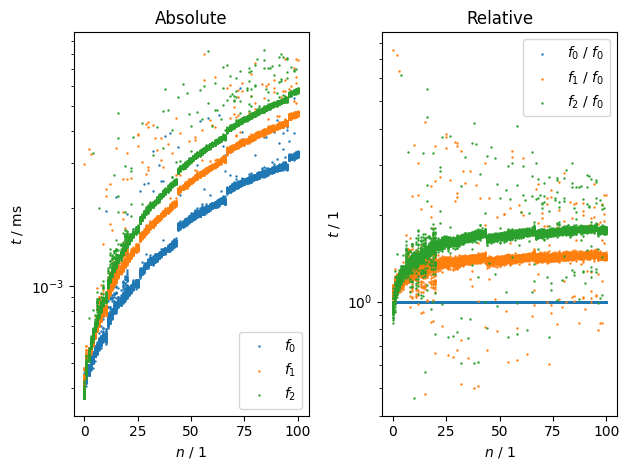

In [23]:
def supplier():
    a, v = random(), randt(randint(0, 100))
    return len(v), v, a

compare(*measure(supplier, div0, div1, div2, scalar=False))

## divelementwise

In [24]:
def divelementwise0(v, w):
    return tuple(map(truediv, v, w))

def divelementwise1(v, w):
    return tuple(vi/wi for vi, wi in zip(v, w))

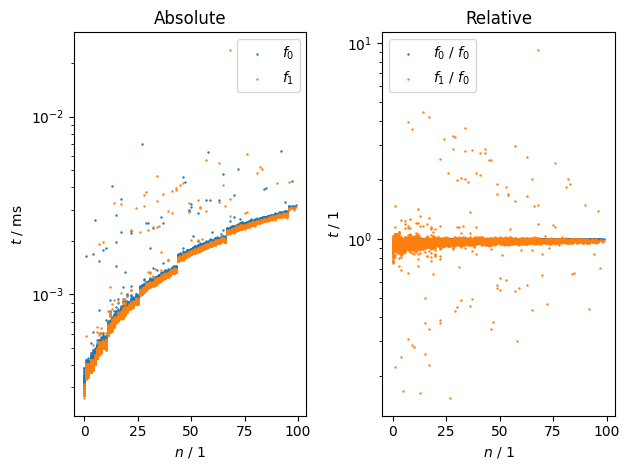

In [25]:
def supplier():
    v, w = randt(randint(0, 100)), randt(randint(0, 100))
    return min(len(v), len(w)), v, w

compare(*measure(supplier, divelementwise0, divelementwise0, scalar=False))